#Data Loading and Pre-processing

In [1]:
# necessary imports
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

In [2]:
# A function to load data from a given directory
def load_data(data_dir):
  data = []
  labels = []
  class_dirs = os.listdir(data_dir)
  
  for direc in class_dirs:
    class_dir = os.path.join(data_dir, direc)
    for imagepath in tqdm(list(paths.list_images(class_dir))):
      image = cv2.imread(imagepath)
      image = cv2.resize(image, (75, 75))  # resizing for uniform size and colab crash issue
      data.append(image)
      labels.append(direc)
  # normalizing and converting to numpy array format
  data = np.array(data, dtype='float')/255.0
  labels = np.array(labels)
  return data, labels

In [3]:
train_dir = "/content/drive/MyDrive/Image-Classification-Dataset/seg_train/seg_train/"
test_dir = "/content/drive/MyDrive/Image-Classification-Dataset/seg_test/seg_test/"
pred_dir = "/content/drive/MyDrive/Image-Classification-Dataset/test/test/"

In [4]:
print('loading train images')
X_train, y_train = load_data(train_dir)

loading train images


100%|██████████| 2274/2274 [20:26<00:00,  1.85it/s]


In [5]:
print('loading validation images')
X_valid, y_valid = load_data(test_dir)

loading validation images


100%|██████████| 501/501 [04:12<00:00,  1.98it/s]


In [6]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_valid = lb.fit_transform(y_valid)

In [7]:
# Function to plot confusion matrix    
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#VGG16 Model

In [8]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

In [9]:
# load VGG16 model without classification layers
vgg16 = VGG16(include_top=False, input_shape=(75, 75, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [10]:
# add new classification layers
flat1 = Flatten()(vgg16.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
class1 = Dense(512, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer

In [11]:
# define the new model
vgg16model = Model(inputs=vgg16.inputs, outputs=output)
for layer in vgg16.layers:
  layer.trainable = False

In [14]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
#Early stopping if training Val_loss doesn't reduce for 7 epochs
es = EarlyStopping(monitor='val_loss', patience=6)

In [15]:
from keras.optimizers import SGD, Adam
# sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
adam = Adam(learning_rate=0.0001)


vgg16model.compile(loss='categorical_crossentropy', 
              optimizer=adam,
              metrics=['accuracy'])


In [16]:
#training the model
H = vgg16model.fit(X_train, y_train, batch_size=64,
              epochs=200,
              validation_data=(X_valid, y_valid),
              callbacks = [lr_reduction, es])     

Epoch 1/200
220/220 [==============================] - 18s 48ms/step - loss: 1.0275 - accuracy: 0.6590 - val_loss: 0.5423 - val_accuracy: 0.8043
Epoch 2/200
220/220 [==============================] - 9s 43ms/step - loss: 0.5138 - accuracy: 0.8157 - val_loss: 0.4908 - val_accuracy: 0.8167
Epoch 3/200
220/220 [==============================] - 10s 44ms/step - loss: 0.4612 - accuracy: 0.8305 - val_loss: 0.4578 - val_accuracy: 0.8340
Epoch 4/200
220/220 [==============================] - 10s 44ms/step - loss: 0.4229 - accuracy: 0.8471 - val_loss: 0.4515 - val_accuracy: 0.8427
Epoch 5/200
220/220 [==============================] - 10s 44ms/step - loss: 0.3969 - accuracy: 0.8604 - val_loss: 0.4382 - val_accuracy: 0.8417
Epoch 6/200
220/220 [==============================] - 10s 44ms/step - loss: 0.3712 - accuracy: 0.8678 - val_loss: 0.4350 - val_accuracy: 0.8407
Epoch 7/200
220/220 [==============================] - 10s 45ms/step - loss: 0.3697 - accuracy: 0.8662 - val_loss: 0.4238 - val_acc

In [17]:
print('loading test images')
x_test, y_test = load_data(pred_dir)

loading test images


100%|██████████| 1330/1330 [11:46<00:00,  1.88it/s]


In [18]:
y_test = lb.fit_transform(y_test)

In [19]:
lossvgg, accuracyvgg = vgg16model.evaluate(x_test, y_test, verbose=1, batch_size = 16)
lossvgg_v, accuracyvgg_v = vgg16model.evaluate(X_valid, y_valid, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracyvgg_v, lossvgg_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracyvgg, lossvgg))
vgg16model.save("/content/vggmodel.h5")

94/94 [==============================] - 3s 25ms/step - loss: 0.4160 - accuracy: 0.8473
Validation: accuracy = 0.847333  ;  loss_v = 0.415972
Test: accuracy = 0.867981  ;  loss = 0.348040


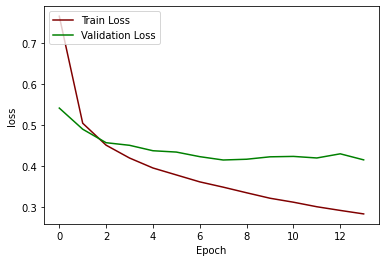

In [20]:
plt.plot(H.history['loss'],
         label='Train Loss',
         c='maroon', ls='-')
plt.plot(H.history['val_loss'],
         label='Validation Loss',
         c='green',ls='-')
 
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.savefig('/content/vgg16plot.png')
plt.show()

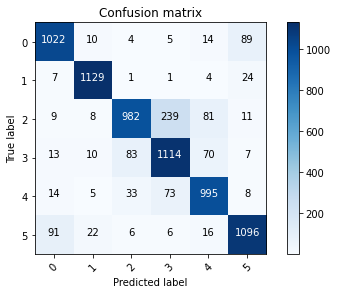

In [21]:
# Predict the values from the validation dataset
Y_predvgg = vgg16model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_predvgg_classes = np.argmax(Y_predvgg,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
conf_matvgg = confusion_matrix(Y_true, Y_predvgg_classes)

 

# plot the confusion matrix
plot_confusion_matrix(conf_matvgg, classes = range(6)) 

In [22]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_predvgg_classes, target_names=["Building","Forest", "Glacier", 'Mountain', 'Sea', 'street']))

              precision    recall  f1-score   support

    Building       0.88      0.89      0.89      1144
      Forest       0.95      0.97      0.96      1166
     Glacier       0.89      0.74      0.81      1330
    Mountain       0.77      0.86      0.81      1297
         Sea       0.84      0.88      0.86      1128
      street       0.89      0.89      0.89      1237

    accuracy                           0.87      7302
   macro avg       0.87      0.87      0.87      7302
weighted avg       0.87      0.87      0.87      7302



Text(0, 0.5, 'Fraction classified incorrectly')

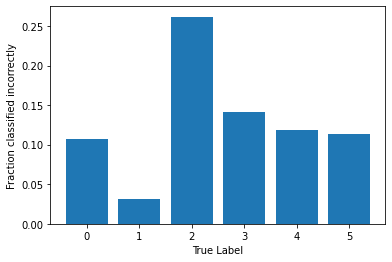

In [23]:
label_frac_error = 1 - np.diag(conf_matvgg) / np.sum(conf_matvgg, axis=1)
plt.bar(np.arange(6),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

#ResNet50 Model

In [24]:
from keras.applications.resnet50 import ResNet50
# load ResNet50 model without classification layers
resnet50 = ResNet50(include_top=False, input_shape=(75, 75, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [25]:
# add new classification layers
flat1 = Flatten()(resnet50.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
class1 = Dense(512, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer

In [26]:
# define the new model
resnetmodel = Model(inputs=resnet50.inputs, outputs=output)
for layer in resnet50.layers:
  layer.trainable = False

In [27]:
resnetmodel.compile(loss='categorical_crossentropy', 
              optimizer=adam,
              metrics=['accuracy'])

In [29]:
#training the model
H_resnet = resnetmodel.fit(X_train, y_train, batch_size=64,
              epochs=200, 
              validation_data=(X_valid, y_valid),
              callbacks = [lr_reduction, es])

Epoch 1/200
220/220 [==============================] - 10s 46ms/step - loss: 1.2504 - accuracy: 0.5179 - val_loss: 1.1695 - val_accuracy: 0.5500
Epoch 2/200
220/220 [==============================] - 9s 40ms/step - loss: 1.1015 - accuracy: 0.5783 - val_loss: 1.0853 - val_accuracy: 0.5870
Epoch 3/200
220/220 [==============================] - 9s 41ms/step - loss: 1.0422 - accuracy: 0.6082 - val_loss: 1.0440 - val_accuracy: 0.5993
Epoch 4/200
220/220 [==============================] - 9s 41ms/step - loss: 1.0048 - accuracy: 0.6256 - val_loss: 1.0233 - val_accuracy: 0.6090
Epoch 5/200
220/220 [==============================] - 9s 41ms/step - loss: 0.9846 - accuracy: 0.6310 - val_loss: 0.9954 - val_accuracy: 0.6303
Epoch 6/200
220/220 [==============================] - 9s 42ms/step - loss: 0.9624 - accuracy: 0.6408 - val_loss: 1.0141 - val_accuracy: 0.6040
Epoch 7/200
220/220 [==============================] - 9s 42ms/step - loss: 0.9408 - accuracy: 0.6496 - val_loss: 0.9688 - val_accuracy

In [30]:
lossresnet, accuracyresnet = resnetmodel.evaluate(x_test, y_test, verbose=1, batch_size = 16)
lossresnet_v, accuracyresnet_v = resnetmodel.evaluate(X_valid, y_valid, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracyresnet_v, lossresnet_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracyresnet, lossresnet))
resnetmodel.save("/content/resnetmodel.h5")

94/94 [==============================] - 2s 23ms/step - loss: 0.8218 - accuracy: 0.7017
Validation: accuracy = 0.701667  ;  loss_v = 0.821781
Test: accuracy = 0.706930  ;  loss = 0.776809


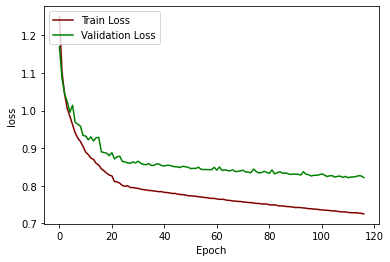

In [31]:
plt.plot(H_resnet.history['loss'],
         label='Train Loss',
         c='maroon', ls='-')
plt.plot(H_resnet.history['val_loss'],
         label='Validation Loss',
         c='green',ls='-')
 
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.savefig('/content/resnetplot.png')
plt.show()

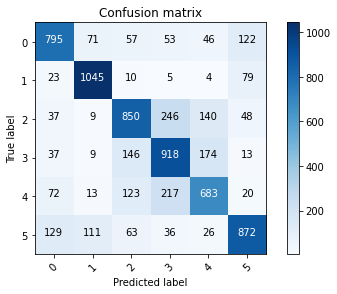

In [32]:
# Predict the values from the validation dataset
Y_predresnet = resnetmodel.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_predresnet_classes = np.argmax(Y_predresnet,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
conf_matresnet = confusion_matrix(Y_true, Y_predresnet_classes)

 

# plot the confusion matrix
plot_confusion_matrix(conf_matresnet, classes = range(6)) 

In [33]:
print(classification_report(Y_true, Y_predresnet_classes, target_names=["Building","Forest", "Glacier", 'Mountain', 'Sea', 'street']))

              precision    recall  f1-score   support

    Building       0.73      0.69      0.71      1144
      Forest       0.83      0.90      0.86      1166
     Glacier       0.68      0.64      0.66      1330
    Mountain       0.62      0.71      0.66      1297
         Sea       0.64      0.61      0.62      1128
      street       0.76      0.70      0.73      1237

    accuracy                           0.71      7302
   macro avg       0.71      0.71      0.71      7302
weighted avg       0.71      0.71      0.71      7302



Text(0, 0.5, 'Fraction classified incorrectly')

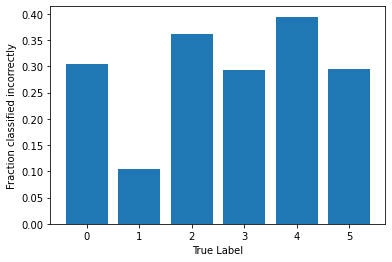

In [34]:
label_frac_error = 1 - np.diag(conf_matresnet) / np.sum(conf_matresnet, axis=1)
plt.bar(np.arange(6),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

#InceptionV3 model

In [41]:
import keras.applications as apps
inception = apps.InceptionV3(include_top=False, input_shape=(75, 75, 3))

In [42]:
# add new classification layers
flat1 = Flatten()(inception.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
class1 = Dense(512, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer

In [43]:
# define the new model
inceptionmodel = Model(inputs=inception.inputs, outputs=output)
for layer in inception.layers:
  layer.trainable = False

In [44]:
inceptionmodel.compile(loss='categorical_crossentropy', 
              optimizer=adam,
              metrics=['accuracy'])

In [45]:
#training the model
H_inception = inceptionmodel.fit(X_train, y_train, batch_size=64,
              epochs=200, 
              validation_data=(X_valid, y_valid),
              callbacks = [lr_reduction, es])

Epoch 1/200
220/220 [==============================] - 11s 32ms/step - loss: 1.3448 - accuracy: 0.4969 - val_loss: 0.8959 - val_accuracy: 0.6847
Epoch 2/200
220/220 [==============================] - 6s 25ms/step - loss: 0.8213 - accuracy: 0.7177 - val_loss: 0.7976 - val_accuracy: 0.7120
Epoch 3/200
220/220 [==============================] - 6s 25ms/step - loss: 0.7456 - accuracy: 0.7408 - val_loss: 0.7531 - val_accuracy: 0.7237
Epoch 4/200
220/220 [==============================] - 6s 26ms/step - loss: 0.6808 - accuracy: 0.7650 - val_loss: 0.7272 - val_accuracy: 0.7313
Epoch 5/200
220/220 [==============================] - 6s 26ms/step - loss: 0.6550 - accuracy: 0.7684 - val_loss: 0.7087 - val_accuracy: 0.7387
Epoch 6/200
220/220 [==============================] - 6s 25ms/step - loss: 0.6264 - accuracy: 0.7814 - val_loss: 0.6955 - val_accuracy: 0.7403
Epoch 7/200
220/220 [==============================] - 6s 25ms/step - loss: 0.6085 - accuracy: 0.7880 - val_loss: 0.6850 - val_accuracy

In [46]:
lossinception, accuracyinception = inceptionmodel.evaluate(x_test, y_test, verbose=1, batch_size = 16)
lossinception_v, accuracyinception_v = inceptionmodel.evaluate(X_valid, y_valid, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracyresnet_v, lossresnet_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracyresnet, lossresnet))
inceptionmodel.save("/content/inceptionmodel.h5")

94/94 [==============================] - 2s 19ms/step - loss: 0.6235 - accuracy: 0.7687
Validation: accuracy = 0.701667  ;  loss_v = 0.821781
Test: accuracy = 0.706930  ;  loss = 0.776809


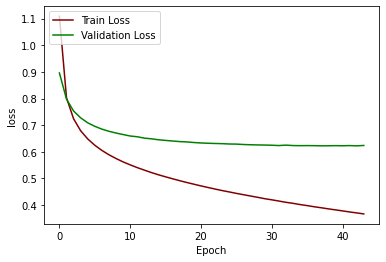

In [47]:
plt.plot(H_inception.history['loss'],
         label='Train Loss',
         c='maroon', ls='-')
plt.plot(H_inception.history['val_loss'],
         label='Validation Loss',
         c='green',ls='-')
 
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.savefig('/content/inceptionplot.png')
plt.show()

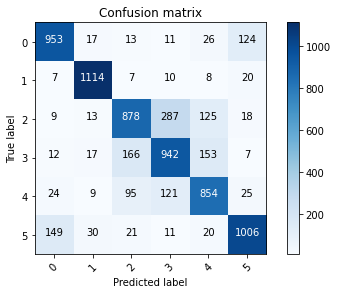

In [48]:
# Predict the values from the validation dataset
Y_predinception = inceptionmodel.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_predinception_classes = np.argmax(Y_predinception,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
conf_matinception = confusion_matrix(Y_true, Y_predinception_classes)

 

# plot the confusion matrix
plot_confusion_matrix(conf_matinception, classes = range(6)) 

In [49]:
print(classification_report(Y_true, Y_predinception_classes, target_names=["Building","Forest", "Glacier", 'Mountain', 'Sea', 'street']))

              precision    recall  f1-score   support

    Building       0.83      0.83      0.83      1144
      Forest       0.93      0.96      0.94      1166
     Glacier       0.74      0.66      0.70      1330
    Mountain       0.68      0.73      0.70      1297
         Sea       0.72      0.76      0.74      1128
      street       0.84      0.81      0.83      1237

    accuracy                           0.79      7302
   macro avg       0.79      0.79      0.79      7302
weighted avg       0.79      0.79      0.79      7302



Text(0, 0.5, 'Fraction classified incorrectly')

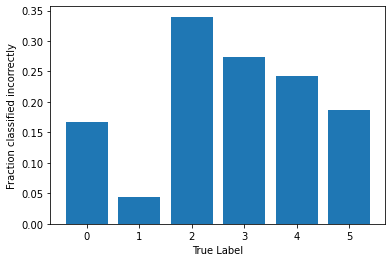

In [50]:
label_frac_error = 1 - np.diag(conf_matinception) / np.sum(conf_matinception, axis=1)
plt.bar(np.arange(6),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')